# Title
*All Life Bank Clustering_20200326_01_VinuPillai*

## Overview
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

## Purpose
**To identify different segments in the existing customer** based on their spending patterns as well as past interaction with the bank.

Key questions to answer is
* How many different segments of customers are there?
* How are these segments different from each other?
* What are your recommendations to the bank on how to better market to and service these customers?

Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.

## Methodology
* To Perform univariate analysis on the data to better understand the variables at your disposal and to get an idea about the no of clusters. 
* Perform EDA and take insights out.
* Create visualizations to explore data and present the insights
* Properly comment on the codes and provide explanations of the steps taken in the notebook
* Execute hierarchical and K-means clustering (with different linkages) and do relevant visualisations (elbow plot, dendrograms etc)
* Perform a silhouette analysis

# Setup

## Library import
We import all the required Python libraries

In [1]:
# Data manipulation modules
import pandas as pd
import numpy as np

# Scikit learn related modules
from sklearn.preprocessing import PowerTransformer

from scipy.stats import zscore

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist

import warnings
warnings.filterwarnings('ignore')

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations Seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# Data import
All the required data for the analysis is imported here.

In [2]:
customerCreditCardDf = pd.read_excel("Credit Card Customer Data.xlsx")
customerCreditCardDf = customerCreditCardDf.drop(columns=['Sl_No'])
customerCreditCardDf.head()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,87073,100000,2,1,1,0
1,38414,50000,3,0,10,9
2,17341,50000,7,1,3,4
3,40496,30000,5,1,1,4
4,47437,100000,6,0,12,3


# Data Analysis

## Data Summary
View the data based on the 5 point summary

In [3]:
customerCreditCardDf.describe()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


Average credit limit is in a different scale and will need normalization before clustering

In [4]:
customerCreditCardDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Customer Key         660 non-null    int64
 1   Avg_Credit_Limit     660 non-null    int64
 2   Total_Credit_Cards   660 non-null    int64
 3   Total_visits_bank    660 non-null    int64
 4   Total_visits_online  660 non-null    int64
 5   Total_calls_made     660 non-null    int64
dtypes: int64(6)
memory usage: 31.1 KB


There are no null values in any of the columns

In [5]:
customerCreditCardDf.isna().sum()

Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

## Univariate Plots
Plotting the features to understand the variables and to understand the number of clusters possible

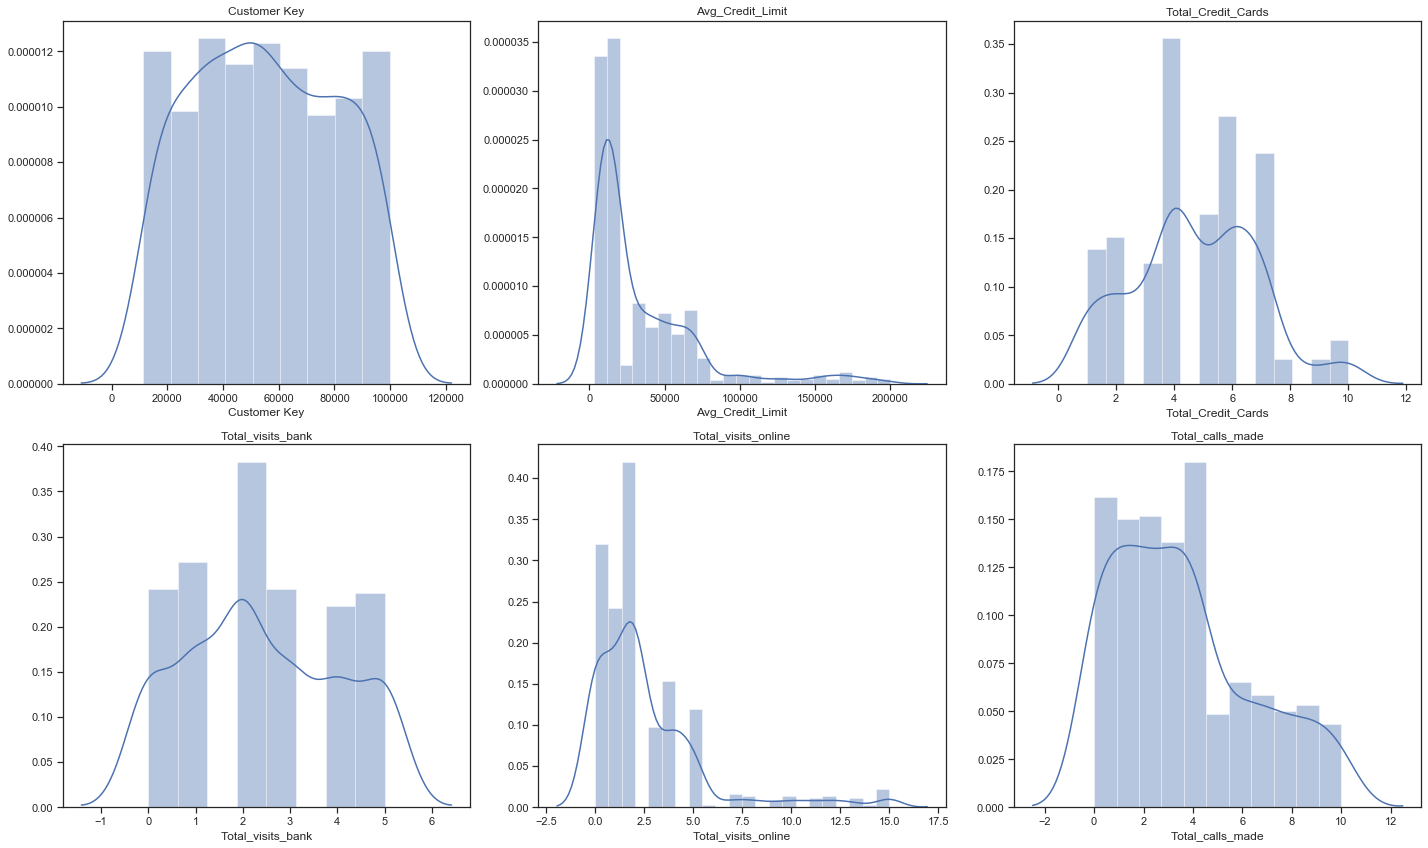

In [6]:
fig = plt.figure(figsize=(20, 35))
for feature, num in zip(customerCreditCardDf.columns, range(1, len(customerCreditCardDf.columns) + 1)):
    ax = fig.add_subplot(6, 3, num)
    ax.set_title(feature)
    sns.distplot(customerCreditCardDf[feature])
plt.tight_layout()
plt.show()

* A look at the plots reveal that the data is having outliers
* Skewness is present in **average credit limit**, **total visits online** and **total calls made** features
* The plots reveal there are 3 to 4 clusters possible due to the spikes in the gaussians

## Pair Plot
A pair plot of all the variables will indicate the distribution of each variables and the correlations with each other

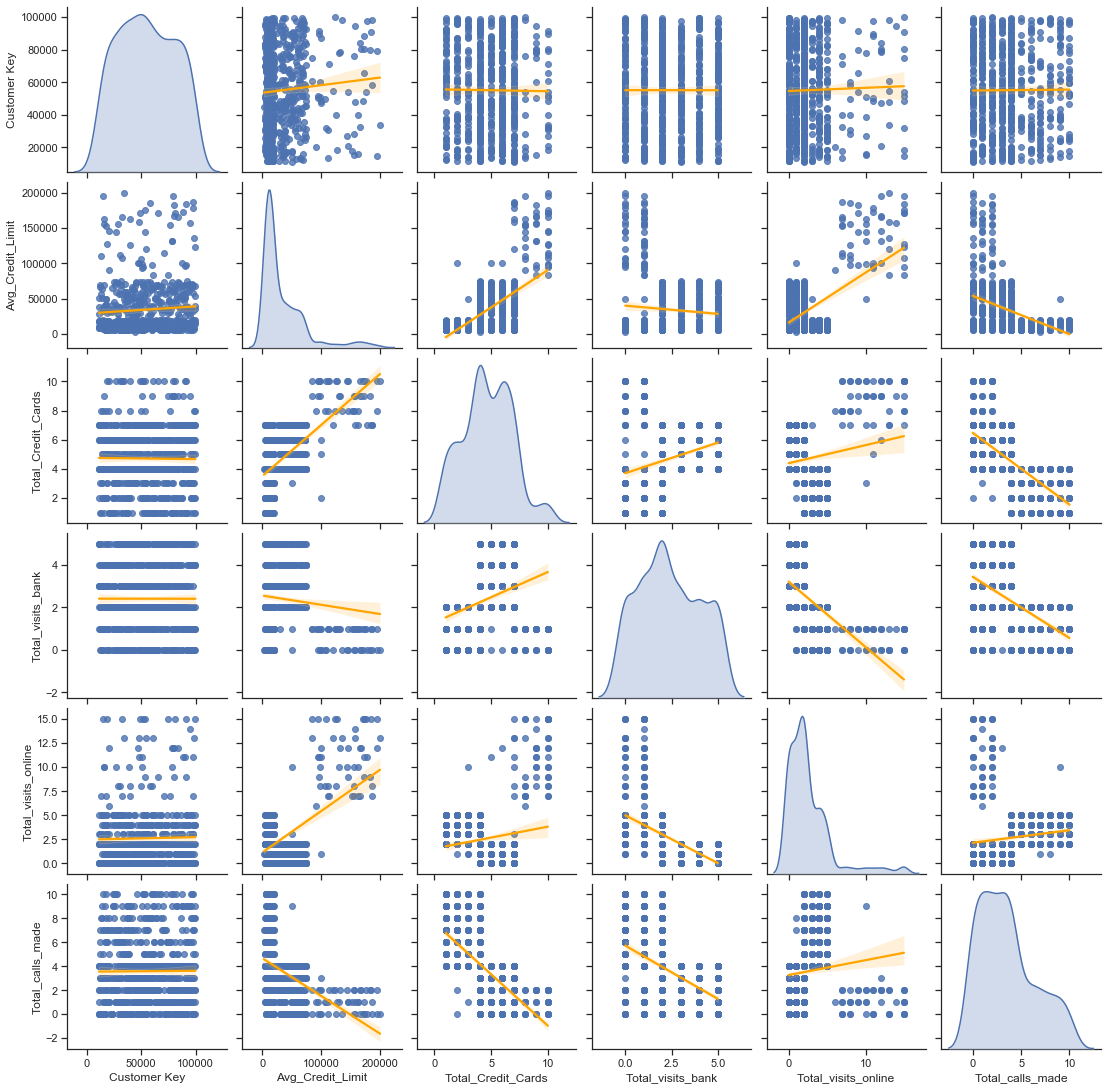

In [7]:
sns.pairplot(customerCreditCardDf, diag_kind='kde', kind='reg', plot_kws={'line_kws':{'color':'orange'}})

It is found that all the features have some sort of positive or negative correlation with each other with the exception of Customer Key being the customer identifier

# Data processing
All the core processing of the notebook is defined in each of the subsections

In [8]:
# Let us first take a copy of the data before we start the first treatment
customerCreditCardDf_baseline = customerCreditCardDf.copy()

## Box Plots for identifying Outliers

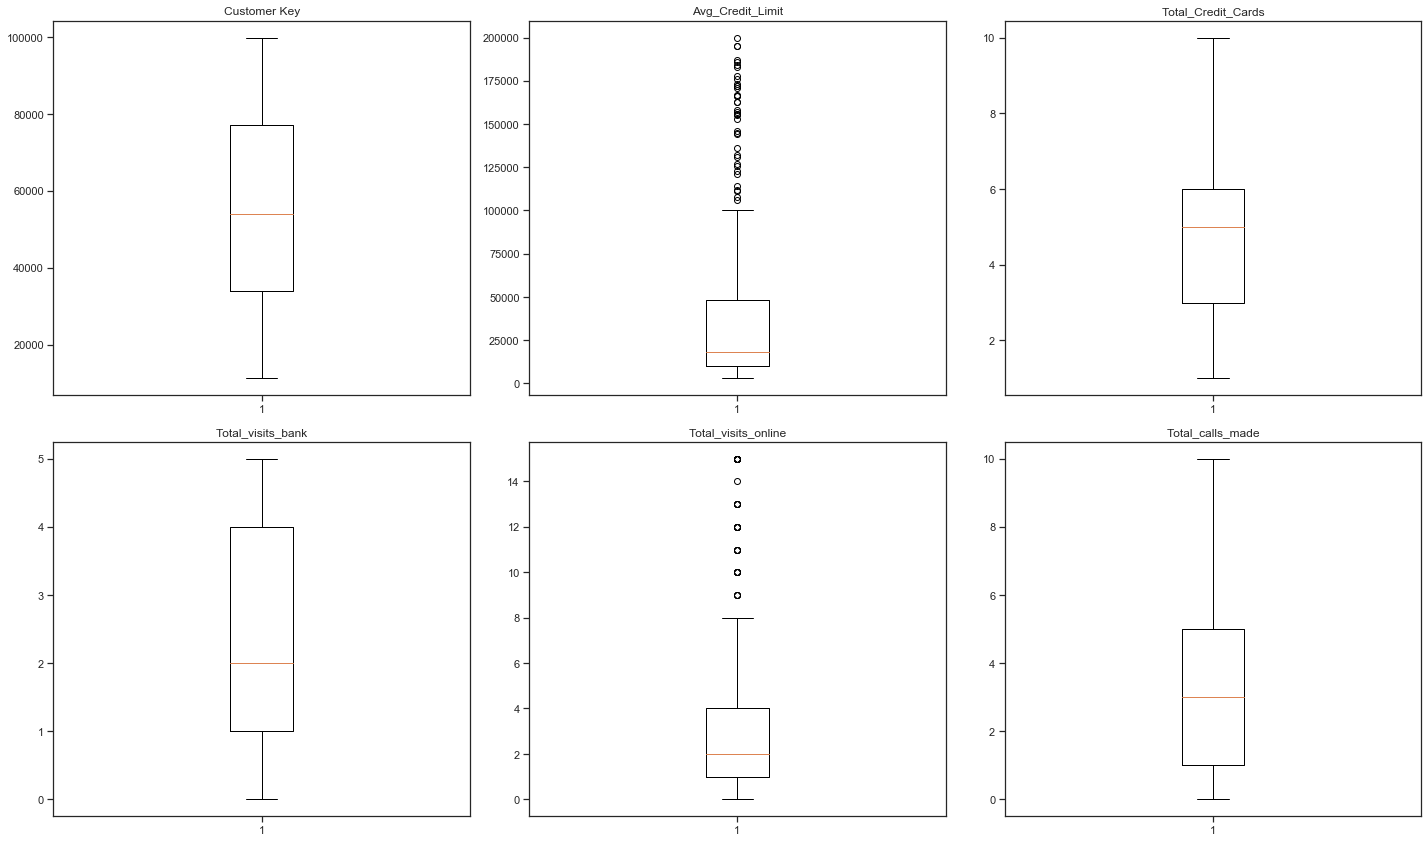

In [9]:
fig = plt.figure(figsize=(20, 35))
for feature, num in zip(customerCreditCardDf_baseline.columns, range(1, len(customerCreditCardDf_baseline.columns) + 1)):
    ax = fig.add_subplot(6, 3, num)
    ax.set_title(feature)
    plt.boxplot(customerCreditCardDf_baseline[feature])
plt.tight_layout()
plt.show()

* The above plots reveal that the **Average_Credit_Limit**, **Total_Visits_online** attributes have a outliers that need to be treated

## Transformation
Applying power transformation to treat outliers and scale the data for further processing

In [10]:
customerCreditCardDf_final = customerCreditCardDf_baseline.copy()
powerTransformer_baseline = PowerTransformer()
for column in customerCreditCardDf_baseline.columns:
    if column != 'Customer Key':
        customerCreditCardDf_baseline[column] = powerTransformer_baseline.fit_transform(customerCreditCardDf_baseline[[column]])

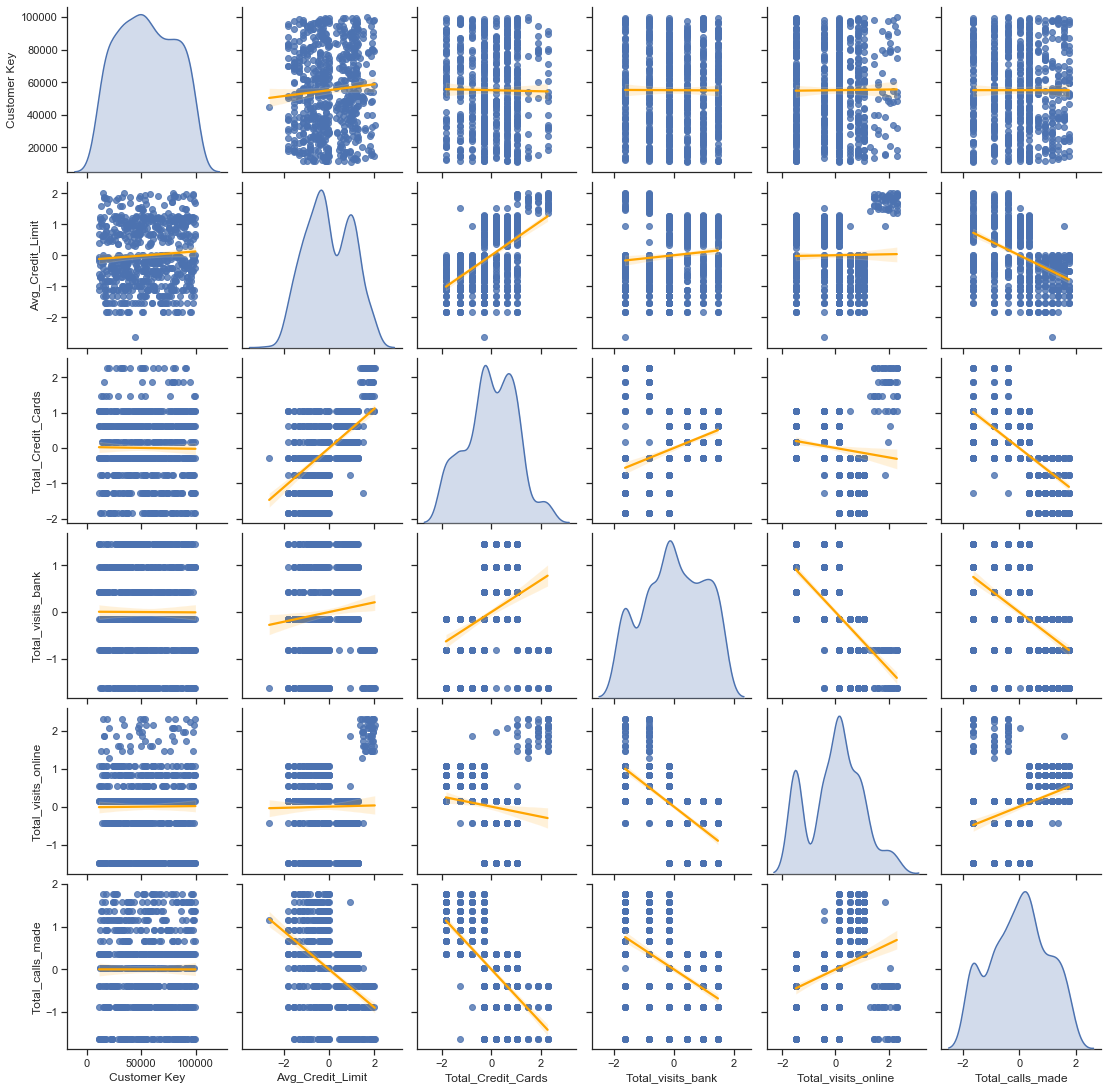

In [11]:
sns.pairplot(customerCreditCardDf_baseline, diag_kind='kde', kind='reg', plot_kws={'line_kws':{'color':'orange'}})

* The Total visits to the bank decreases when the number of visits online increases
* Number of calls made is higher for people with more number of cards
* Total visits online increases with the online visits and visits to the bank is lesser
* People with higher number of cards tend to visit the bank more often

## Box Plots after transformation

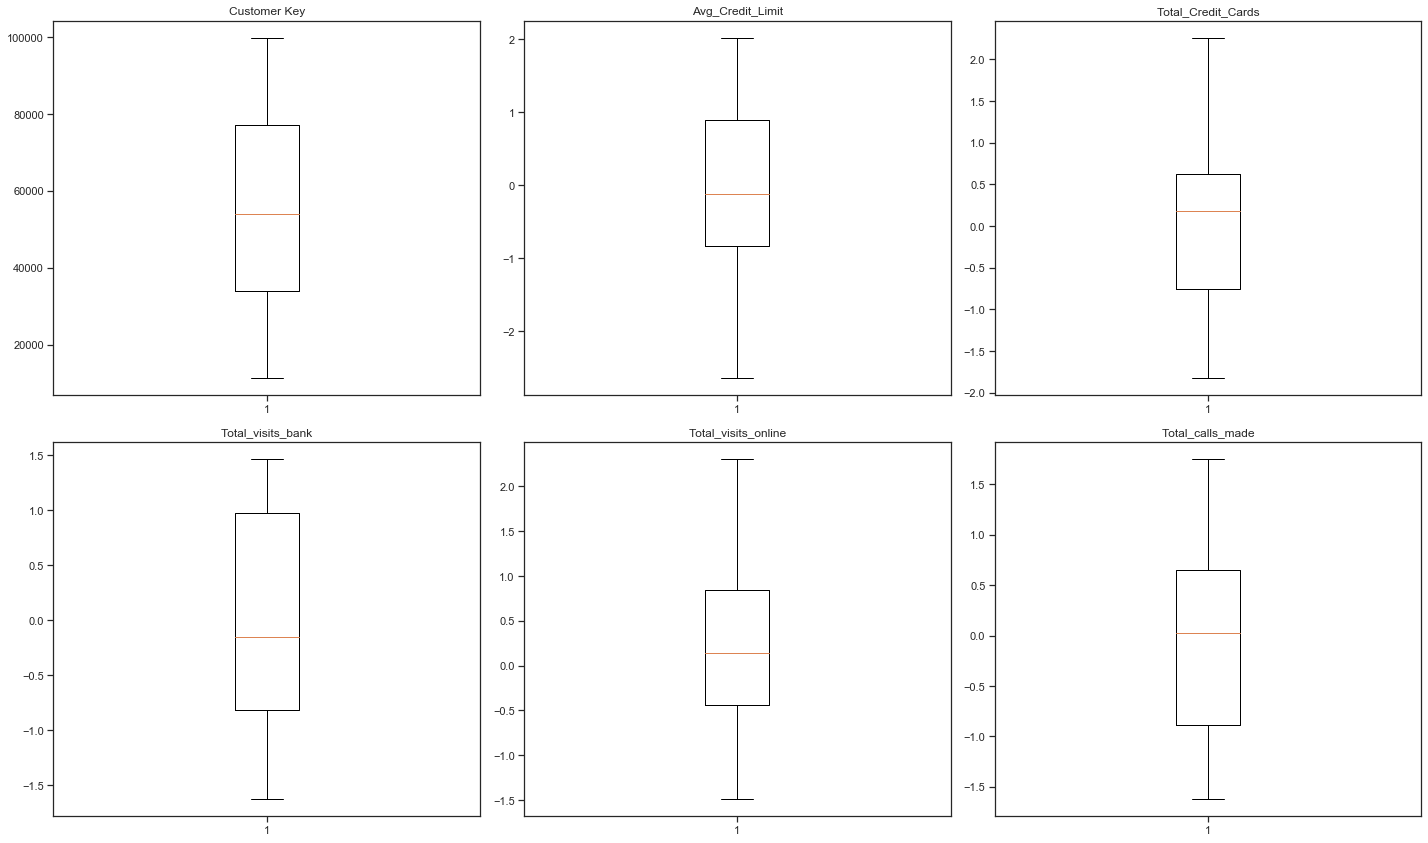

In [12]:
fig = plt.figure(figsize=(20, 35))
for feature, num in zip(customerCreditCardDf_baseline.columns, range(1, len(customerCreditCardDf_baseline.columns) + 1)):
    ax = fig.add_subplot(6, 3, num)
    ax.set_title(feature)
    plt.boxplot(customerCreditCardDf_baseline[feature])
plt.tight_layout()
plt.show()

As is seen from the plots, the outliers are complete removed and the scale of the data has all become uniform. This will help us in the modeling phase

## Normalize using Zscore
Apply the zscore to the columns to normalize the data

In [13]:
# We take all the column values and apply the zscore function except the customer key attribute
numeric_cols = customerCreditCardDf_baseline.select_dtypes(include=[np.int64, np.float64]).columns
customerCreditCardDf_baseline[numeric_cols[numeric_cols != 'Customer Key']] = customerCreditCardDf_baseline[numeric_cols[numeric_cols != 'Customer Key']].apply(zscore)

# View the data after applying zscore
customerCreditCardDf_baseline.head()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,87073,1.515310,-1.271636,-0.814744,-0.443077,-1.623874
1,38414,0.929111,-0.760366,-1.626437,1.852096,1.567858
2,17341,0.929111,1.048279,-0.814744,0.536837,0.358752
3,40496,0.435240,0.180363,-0.814744,-0.443077,0.358752
4,47437,1.515310,0.621680,-1.626437,2.056966,0.021536


Extract the data to be processed during clustering. Removing the customer key column

In [14]:
# Remove the customer key column for cluster analysis
customerCreditCardDf_kmeans = customerCreditCardDf_baseline[numeric_cols[numeric_cols != 'Customer Key']]

## Cluster Analysis

### KMeans & Cluster errors

We first explore a number of possible clusters in a range of 1 to 15 to find out the best possible cluster number.

**Elbow method** is used to then identify which cluster can be chosen for the given data. **KMeans** clustering is used

In [15]:
# explore a range between 1 to 15
cluster_range = range(2,15)

In [16]:
# Creating clusters
cluster_errors = []
for num_clusters in cluster_range:
    # create a kmeans and explore for each cluster size and capture the errors
    clusters = KMeans(num_clusters, n_init = 5)
    clusters.fit(customerCreditCardDf_kmeans)
    cluster_errors.append(clusters.inertia_)
clusters_df = pd.DataFrame({"num_clusters": cluster_range, "cluster_errors": cluster_errors})
clusters_df[0:15]

,num_clusters,cluster_errors
0,2,1900.816683
1,3,1275.580950
2,4,1039.277948
3,5,932.912160
4,6,855.786564
5,7,791.228002
6,8,746.686777
7,9,699.276518
8,10,662.111942
9,11,637.433303


The above table reveals the cluster errors for each of the cluster sizes. Let us plot this data to identify the right cluster size

### Identify the appropriate clusters with elbow method

A plot of the above data is used to determine what number of cluster should be optimally used depending on the rate of variation in the cluster error

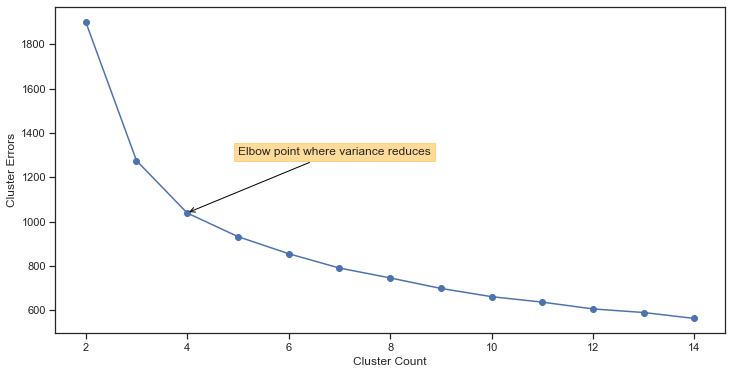

In [17]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
plt.plot(clusters_df.num_clusters, clusters_df.cluster_errors, marker='o')
ax.annotate('Elbow point where variance reduces', xy=(4, 1040), xytext=(5, 1300),
                   arrowprops={'arrowstyle':'->', 'color': 'black'}, 
                   bbox={'pad': 4, 'facecolor':'orange', 'alpha': 0.4, 'edgecolor':'orange'});
plt.xlabel('Cluster Count')
plt.ylabel('Cluster Errors')
plt.show()

The above plot reveals that for cluster size of **4** the elbow appears. Hence it can be used as an appropriate cluster size.

In [18]:
chosen_cluster_size = 4

In [19]:
kmeans = KMeans(n_clusters=chosen_cluster_size, n_init=5, random_state=1)
kmeans.fit(customerCreditCardDf_kmeans)
labels = kmeans.labels_
counts = np.bincount(labels[labels>=0])
cluster_bins = pd.DataFrame({'Cluster Labels' : np.unique(labels), 'Counts' : counts})
cluster_bins

,Cluster Labels,Counts
0,0,224
1,1,219
2,2,167
3,3,50


The above table displays the group of 4 clusters and their distribution of data after clustering 

### Cluster Centroids
A view of the cluster centroids for each of the features is shown below

In [20]:
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(customerCreditCardDf_baseline[numeric_cols[numeric_cols != 'Customer Key']]))
centroid_df.transpose()

,0,1,2,3
Avg_Credit_Limit,-0.725440,0.879430,-0.703008,1.746114
Total_Credit_Cards,-1.079444,0.413069,0.381131,1.753690
Total_visits_bank,-0.911199,0.629417,0.737948,-1.139422
Total_visits_online,0.657257,-0.637659,-0.616760,1.908413
Total_calls_made,1.077908,-0.478729,-0.541732,-0.922809


### Plot per Cluster Group
Let us analyze the data of each cluster for each of the attributes in the normalized dataset

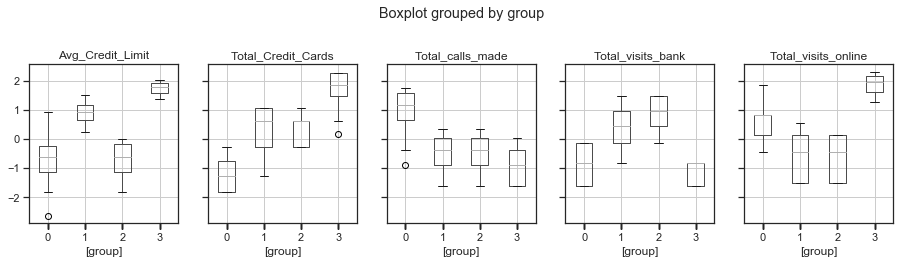

In [21]:
customerCreditCardDf_kmeans_cluster = customerCreditCardDf_kmeans.copy()
predictions = kmeans.predict(customerCreditCardDf_kmeans_cluster)
customerCreditCardDf_kmeans_cluster['group'] = predictions
customerCreditCardDf_kmeans_cluster['group'] = customerCreditCardDf_kmeans_cluster['group'].astype('category')
customerCreditCardDf_kmeans_cluster.boxplot(by = 'group', layout=(3,5), figsize=(15, 10))
plt.show()

There is variation in groups but a few groups have almost similar values and it is hard to differentiate. There are a few outliers coming due to this clustering

### Hierarchical Clustering Analysis

In [22]:
# Let us first take a copy of the data before we start the first treatment
customerCreditCardDf_baseline[numeric_cols[numeric_cols != 'Customer Key']]
customerCreditCardDf_agglomerative = customerCreditCardDf_baseline[numeric_cols[numeric_cols != 'Customer Key']].copy()

<a id='cophenetic_values'></a>

In [23]:
methods = ['single', 'weighted', 'average', 'centroid', 'median', 'ward', 'complete']
cophenetic_values = pd.DataFrame({'methods' : methods})

In [24]:
for num_cluster in cluster_range:
    customerCreditCardDf_agglomerative_list = customerCreditCardDf_agglomerative.copy()
    agglomerative_model = AgglomerativeClustering(n_clusters=num_cluster, affinity='euclidean', linkage='average')
    customerCreditCardDf_agglomerative_list['group'] = agglomerative_model.fit_predict(customerCreditCardDf_agglomerative)
    linkages = list()
    cophenet_corrs = list()
    for method in methods:
        link = linkage(customerCreditCardDf_agglomerative_list, metric='euclidean', method=method)
        cophenet_corr, cophenet_distances = cophenet(link, pdist(customerCreditCardDf_agglomerative_list))
        linkages.append(link)
        cophenet_corrs.append(cophenet_corr)
    cophenetic_values[num_cluster] = cophenet_corrs
cophenetic_values

,methods,2,3,4,5,6,7,8,9,10,11,12,13,14
0,single,0.598735,0.865209,0.861370,0.859790,0.894866,0.910504,0.922828,0.923641,0.852801,0.881378,0.830737,0.856361,0.770247
1,weighted,0.816634,0.877217,0.878019,0.877200,0.894762,0.923828,0.925543,0.902629,0.903058,0.919368,0.881486,0.898674,0.810397
2,average,0.838593,0.887519,0.884661,0.885163,0.903278,0.934745,0.929107,0.939813,0.905887,0.915848,0.887227,0.905565,0.904207
3,centroid,0.830161,0.879144,0.877777,0.878268,0.897791,0.933416,0.926240,0.936766,0.902912,0.913401,0.882804,0.903680,0.901188
4,median,0.811533,0.874295,0.879390,0.877905,0.859973,0.909807,0.926535,0.891539,0.884415,0.921551,0.876722,0.902518,0.809814
5,ward,0.750569,0.836371,0.828642,0.825795,0.844385,0.910092,0.908313,0.812595,0.796337,0.875240,0.680228,0.895683,0.792166
6,complete,0.796255,0.857835,0.851249,0.853698,0.857539,0.901661,0.905609,0.833930,0.852656,0.879813,0.869672,0.902933,0.896049


In [25]:
# getting the maximum cophentic correlation distance from the dataset
cophenetic_values.loc[:, cophenetic_values.columns != 'methods'].max()

2     0.838593
3     0.887519
4     0.884661
5     0.885163
6     0.903278
7     0.934745
8     0.929107
9     0.939813
10    0.905887
11    0.921551
12    0.887227
13    0.905565
14    0.904207
dtype: float64

The above data shows cluster of **9** has the maximum cophenetic correlation. But after cluster size **3** the rate of increase is not very high.

After cluster **3**, the correlation is having highest increase after a step factor of **6** number of clusters. This means we can safely take 3 clusters as an optimum value

### Silhoette Analysis
Let us verify this with Silhoette analysis to see if 3 or 9 can be considered

In [26]:
for n_clusters in cluster_range:
    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(customerCreditCardDf_agglomerative)

    # The silhouette_score gives the average value for all the samples
    silhouette_avg = silhouette_score(customerCreditCardDf_agglomerative, cluster_labels, random_state=1)
    print("For n_clusters =", n_clusters, "The average silhouette_score is", silhouette_avg)

For n_clusters = 2 The average silhouette_score is 0.4024805189486904
For n_clusters = 3 The average silhouette_score is 0.46155819431165584
For n_clusters = 4 The average silhouette_score is 0.351958000701196
For n_clusters = 5 The average silhouette_score is 0.3283363857954408
For n_clusters = 6 The average silhouette_score is 0.31544255195260734
For n_clusters = 7 The average silhouette_score is 0.22001404184218296
For n_clusters = 8 The average silhouette_score is 0.21678455143298464
For n_clusters = 9 The average silhouette_score is 0.22047159810323727
For n_clusters = 10 The average silhouette_score is 0.21338604293651695
For n_clusters = 11 The average silhouette_score is 0.22174994675399978
For n_clusters = 12 The average silhouette_score is 0.2223117480454661
For n_clusters = 13 The average silhouette_score is 0.22904324521151276
For n_clusters = 14 The average silhouette_score is 0.2285026778898369


### Choosing the best Cluster size

The above data shows that the cluster size **3** has the maximum silhouette score and hence can be used as a final number of clusters for modeling

In [27]:
customerCreditCardDf_chosen_cluster = customerCreditCardDf_agglomerative.copy()
# Choosing the cluster size of 3 based on our earlier analysis
best_cluster = 3

### Optimum Cluster Labeling

In [28]:
agglomerative_model = AgglomerativeClustering(n_clusters=best_cluster, affinity='euclidean', linkage='average')
customerCreditCardDf_chosen_cluster['group'] = agglomerative_model.fit_predict(customerCreditCardDf_agglomerative)

### Plotting with the actual Dataset

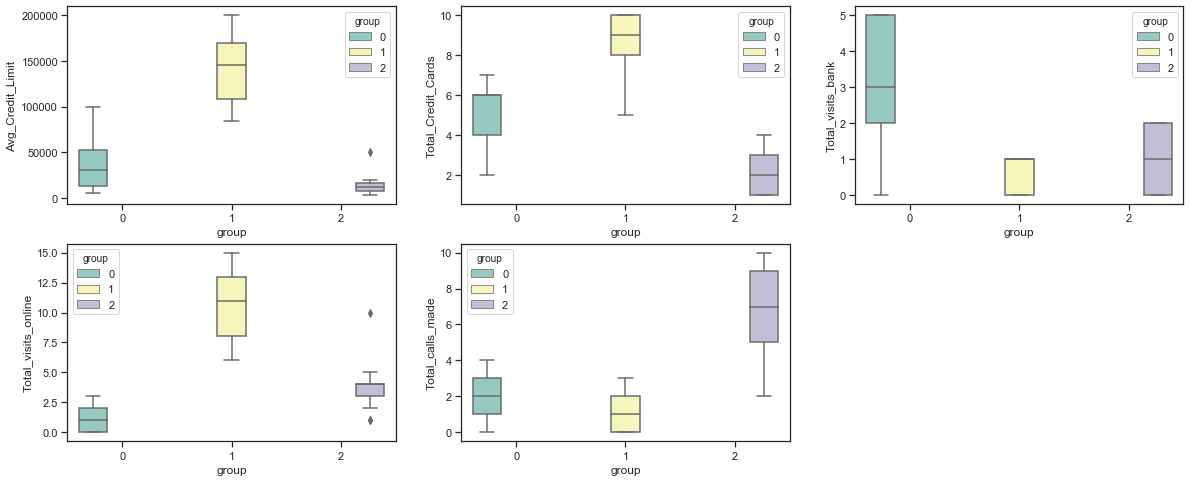

In [29]:
customerCreditCardDf_final = customerCreditCardDf_final[numeric_cols[numeric_cols != 'Customer Key']]
columns = customerCreditCardDf_final.columns
customerCreditCardDf_final['group'] = customerCreditCardDf_chosen_cluster['group']
fig = plt.figure(figsize=(20,8))
for i, column in zip(range(1, len(columns) + 1), columns):
    ax = fig.add_subplot(2, 3, i)
    sns.boxplot(x='group', y=column, data=customerCreditCardDf_final, hue='group', palette='Set3', ax=ax)
plt.show()

The above plot can be analyzed and the following inference can be derived from the nature of clusters
* **average_credit_limit Characteristics**
    - Value is between 15000 and around 90000, it will belong to group 1
    - Value is 90000 and above, it will belong to group 2
    - Value is less than 15000 it will be group 3
* **Total_Credit_Cards Characteristics**
    - Value is between 3 and 7 it is group 1
    - Value is 7 and above it is group 2
    - Value is less than 3 it is group 3
* **Total_visits_bank Characteristics**
    - Value is 2 and above it is group 1
    - Value 1 or less its group 2
    - Value is 2 or less it is group 3. For overlapping range, other attribute values can be used to specifically choose the group
* **Total_visits_online Characteristics**
    - Value is 2.5 and less it is group 1
    - Value is 7 and above is group 2
    - value between 2.5 and 7 is group 3
* **Total_calls_made Characteristics**
    - Value is 4 and less can be group 1
    - Value is 2 and less can be group 2. For overlapping range, other attribute values can be used to specifically choose the group
    - Value of 4 and above is group 3
    
Group names can now be assigned to each group based on the above characteristics

## Cluster Plot with Dendrogram
Plotting the cluster with the best cluster size

'Average' method is chosen since it was found to be the best linkage from cophenetic values in section [Section 5.5.5](#cophenetic_values)

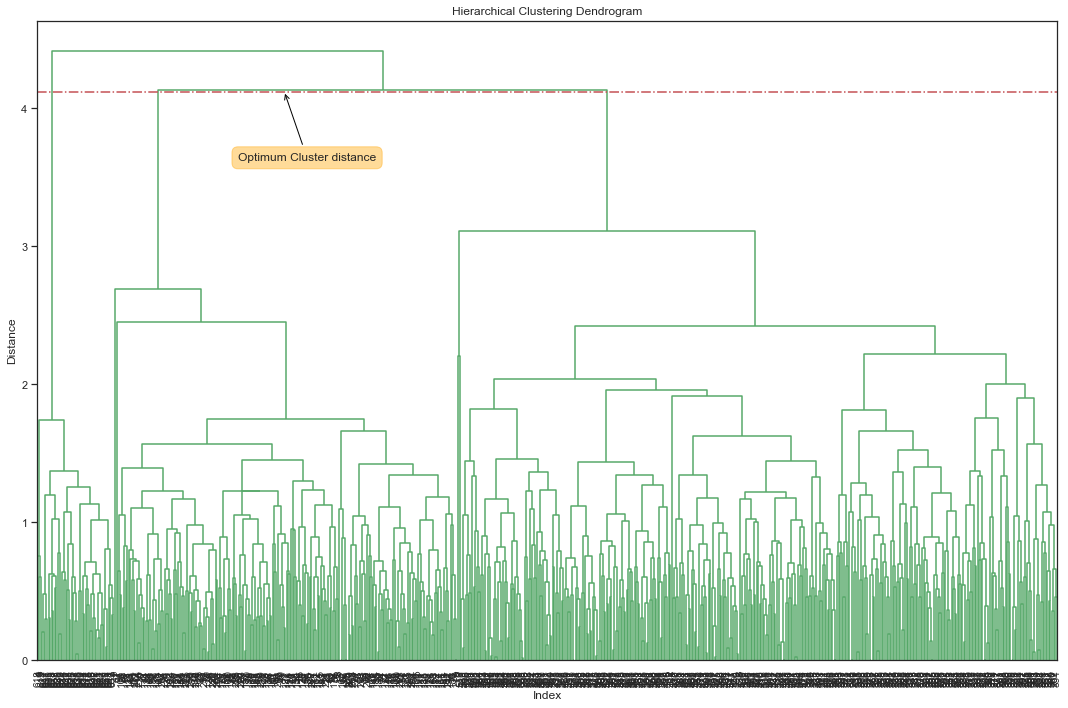

In [30]:
agglomerative_model = AgglomerativeClustering(n_clusters=best_cluster, affinity='euclidean', linkage='average')
# Since average was found to be the best linkage for cluster 3 from 
# cophenetic_values data frame above from section 5.5.5
link = linkage(customerCreditCardDf_chosen_cluster, metric='euclidean', method='average')
cophenet_corr, cophenet_distances = cophenet(link, pdist(customerCreditCardDf_chosen_cluster))
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index')
plt.ylabel('Distance')
dendrogram(link, leaf_rotation=90, color_threshold=600,  leaf_font_size=10)
# Since the best cluster is the highest chosen for agglomerative clustering 
# hence using the first cophenetic distance
ax.axhline(y=cophenet_distances[0] - 0.01, linewidth=1.5, color='r', linestyle='dashdot', label=cophenet_distances[0] - 0.01)
ax.annotate('Optimum Cluster distance', xy=(1600, cophenet_distances[0] - 0.01), xytext=(1300, cophenet_distances[0] - 0.01 - 0.5),
                   arrowprops={'arrowstyle':'->', 'color': 'black'}, 
                   bbox={'boxstyle': 'round', 'pad': 0.5, 'facecolor':'orange', 'alpha': 0.4, 'edgecolor':'orange'});
plt.tight_layout()
plt.show()